## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import os
from os.path import basename

%matplotlib inline

##1a) Camera Calibration - Load Images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    #print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        if False:
            rootname = os.path.splitext(basename(fname))[0]
            #print(rootname)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv2.imwrite('./output_images/chessboard/' + rootname +'_Chessboard.jpg', img)
            plt.figure()
            plt.imshow(img)

##1) Camera Calibration - Actual Calibration

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,(img.shape[1],img.shape[0]),None, None)

for fname in images:
    img = cv2.imread(fname)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_ChessboardUndistorted.jpg', dst)
    
    if False:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori')
        ax2.imshow(dst)
        ax2.set_title('Undistorted')

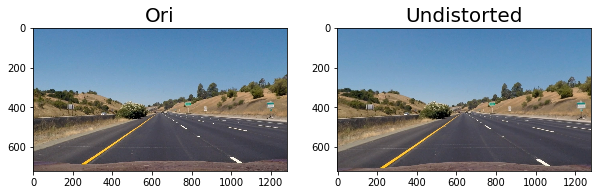

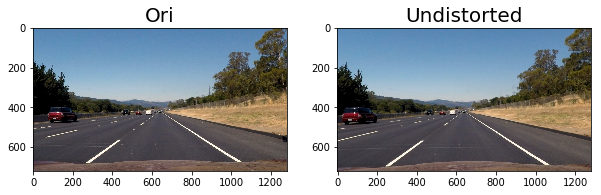

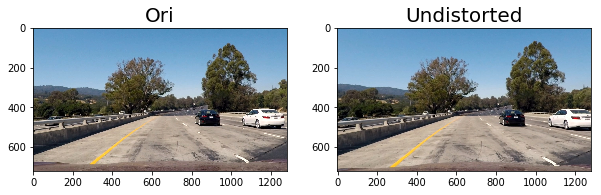

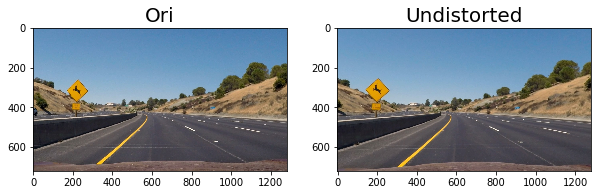

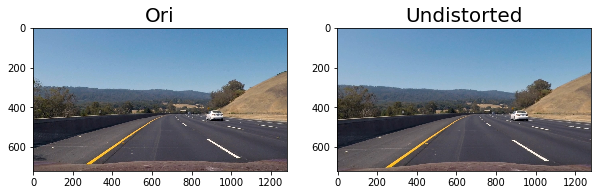

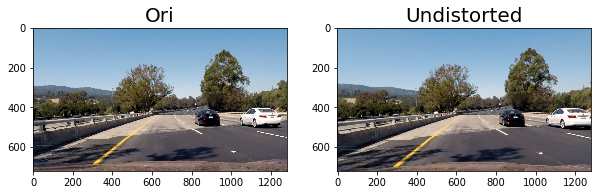

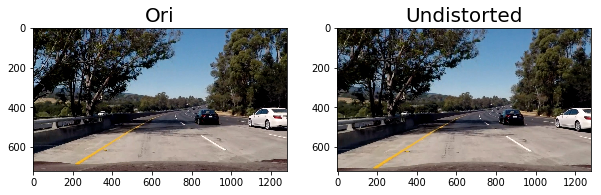

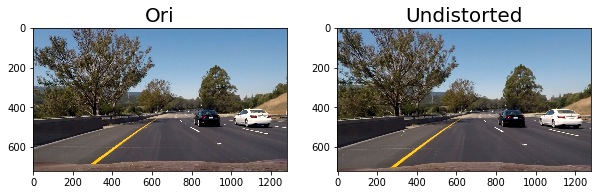

In [5]:
test_images = []
test_images_unsorted = []

images = glob.glob('test_images/*.jpg')

for fname in images:
    #print(fname)
    img = mpimg.imread(fname)
    test_images.append(img)
    dst = cv2.undistort(img,mtx,dist,None,mtx)
    test_images_unsorted.append(dst)
    
    rootname = os.path.splitext(basename(fname))[0]
    cv2.imwrite('./output_images/undistorted/' + rootname +'_Undistorted.jpg', cv2.cvtColor(dst,cv2.COLOR_RGB2BGR))
    if True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(img)
        ax1.set_title('Ori', fontsize=20)
        ax2.imshow(dst)
        ax2.set_title('Undistorted', fontsize=20)
    

Check Projection

In [6]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    plt.imshow(sx_binary,cmap='gray')
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sx_binary

In [7]:
def perspective_swap(img, swap_back=False, draw_regions=False, plot_enable=False):
    img_size = [img.shape[1],img.shape[0]]
    
    srcpts = np.array(
        #[[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        #[((img_size[0] / 6) - 10), img_size[1]],
        #[(img_size[0] * 5 / 6) + 60, img_size[1]],
        #[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        [[(img_size[0] / 2) - 45, img_size[1] / 2 + 100],
        [((img_size[0] / 6) + 80), img_size[1]],
        [(img_size[0] * 5 / 6) - 30, img_size[1]],
        [(img_size[0] / 2 + 45), img_size[1] / 2 + 100]])

    dstpts = np.array(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
       
    if swap_back: 
        M = cv2.getPerspectiveTransform(np.float32([dstpts]), np.float32([srcpts]))
    else:
        M = cv2.getPerspectiveTransform(np.float32([srcpts]), np.float32([dstpts]))
    
    dst = cv2.warpPerspective(img, M, (img_size[0],img_size[1]), flags=cv2.INTER_LINEAR)
    
    dst2 = cv2.polylines(np.copy(dst), np.int32([dstpts]), 2, (255,0,0), thickness=3)
    img2 = cv2.polylines(np.copy(img), np.int32([srcpts]), 2, (255,0,0), thickness=3)
    
    if plot_enable:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Ori', fontsize=20)
        ax2.set_title('Transform', fontsize=20)
        
        if draw_regions:
            ax1.imshow(img2)
            ax2.imshow(dst2)
        else:
            ax1.imshow(img)
            ax2.imshow(dst)
            
    return dst

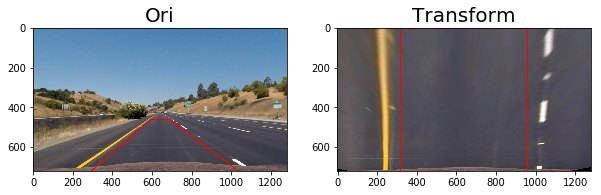

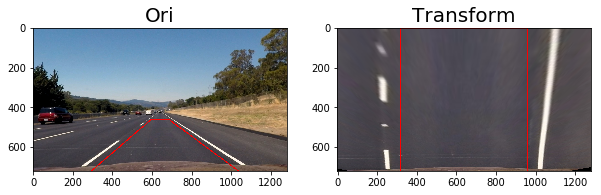

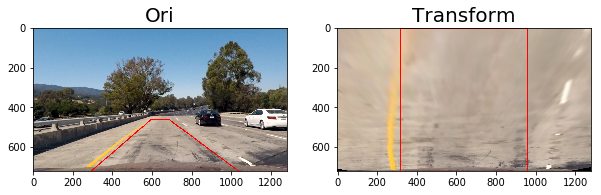

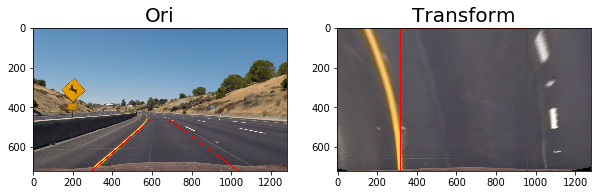

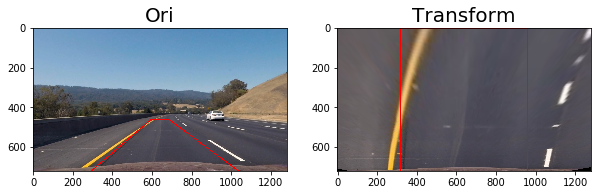

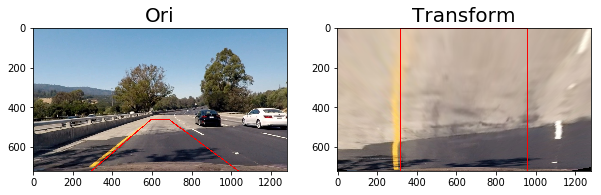

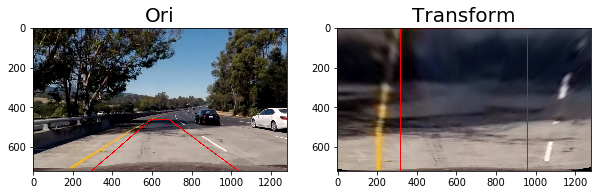

In [8]:
img_project_to = []

for cur_img in test_images_unsorted:
    dst = perspective_swap(cur_img,draw_regions=True,plot_enable=True)
    img_project_to.append(dst)

   


In [9]:
def conv2LSBinary(img, s_thresh = (170,255),sx_thresh=(20,100), sy_thresh=(20,100)):
    
    #Gray Image for Sobel
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Sobel X
    sx = cv2.Sobel(gray,cv2.CV_64F,1,0)
    sx = np.absolute(sx)
    sx_scaled = np.uint8(255*sx/np.max(sx))
    sx_binary = np.zeros_like(sx_scaled)
    sx_binary[(sx_scaled >= sx_thresh[0]) & (sx_scaled <= sx_thresh[1])] = 1
    
    #Sobel Y
    #sy = cv2.Sobel(gray,cv2.CV_64F,0,1)
    #sy = np.absolute(sy)
    #sy_scaled = np.uint8(255*sy/np.max(sy))
    #sy_binary = np.zeros_like(sy_scaled)
    #sy_binary[(sy_scaled >= sy_thresh[0]) & (sy_scaled <= sy_thresh[1])] = 1
    
    #Extract Saturation
    img_hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    saturation = img_hls[:,:,2]
    
    #Saturation Thresholding
    sat = np.absolute(saturation)
    #sat_scaled = np.uint8(255*sat/np.max(sat))
    saturation_bin = np.zeros_like(sat)
    saturation_bin[(sat >= s_thresh[0]) & (sat <= s_thresh[1])] = 1
    
    #Combine Thresholds
    sxy_binary = np.zeros_like(sx_binary)
    sxy_binary[(sx_binary==1) | (saturation_bin==1)] = 1
    
    return sxy_binary


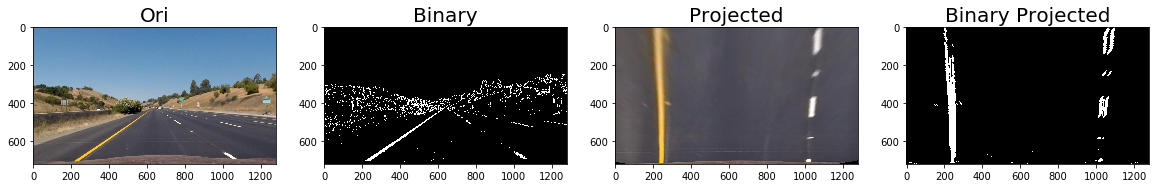

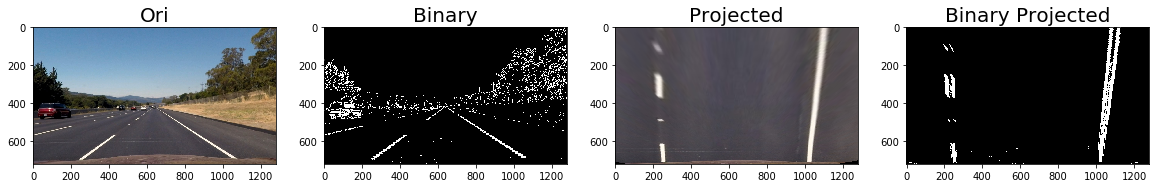

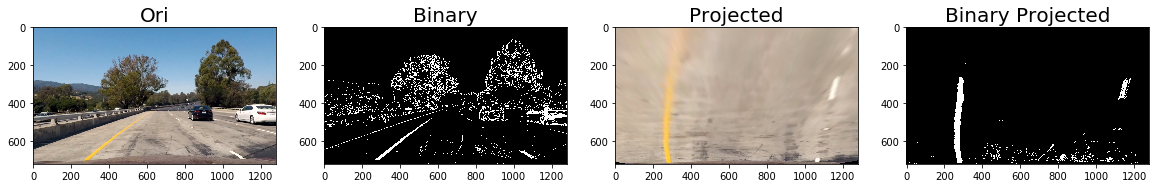

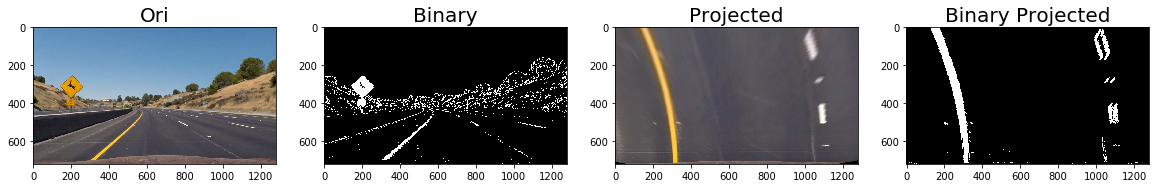

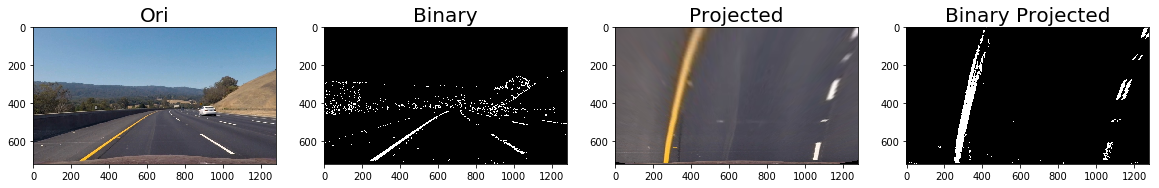

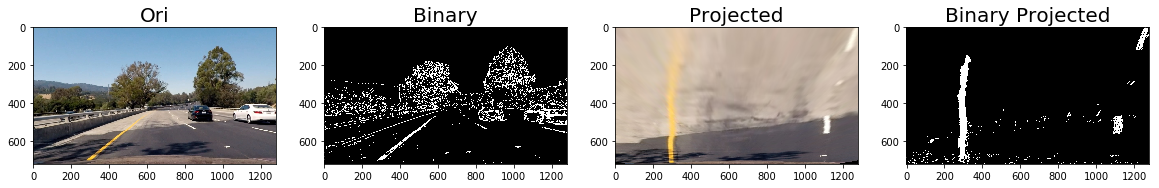

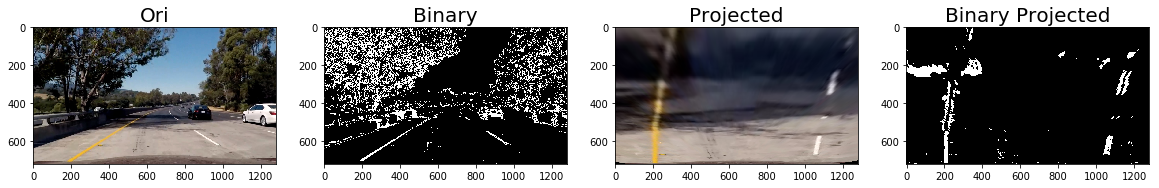

In [10]:
bin_warp_imgs = []

for cur_img, cur_img_proj in zip(test_images_unsorted, img_project_to):
    img_out_bin = conv2LSBinary(cur_img)
    img_out_projected_Bin = conv2LSBinary(cur_img_proj)
    bin_warp_imgs.append(img_out_projected_Bin)
    if True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(cur_img)
        ax2.set_title('Binary', fontsize=20)
        ax2.imshow(img_out_bin, cmap='gray')
        ax3.set_title('Projected', fontsize=20)
        ax3.imshow(cur_img_proj, cmap='gray')
        ax4.set_title('Binary Projected', fontsize=20)
        ax4.imshow(img_out_projected_Bin, cmap='gray')

In [11]:
def detect_lane_edges(bin_warped_img, plot_enable=False):
    output_img = np.dstack((bin_warped_img,bin_warped_img,bin_warped_img))*255
    histogram = np.sum(bin_warped_img[int(bin_warped_img.shape[0]/2):,:], axis=0)
    histograminv = bin_warped_img.shape[0] - histogram
    
    window_count = 9
    window_height = bin_warped_img.shape[0] / window_count
    window_height = int(window_height)
    window_deltaX = 75
    margin = 100
    midpoint = np.int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    
    # Multiple Windows worth of px for polyfit
    left_lane_inds = []
    right_lane_inds = []
    
    nonzero = bin_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_window_anchor = leftx_base
    right_window_anchor = rightx_base
    
    for cur_win in range(window_count):
        
        # Shared Top / Bottom
        bottom = bin_warped_img.shape[0] - window_height * (cur_win + 1)
        top = bin_warped_img.shape[0] - window_height * (cur_win)
        
        # L/R for Left Window
        Lleft = int(left_window_anchor) - window_deltaX
        Lright = int(left_window_anchor) + window_deltaX
        
        cv2.rectangle(output_img,(Lright,bottom),(Lleft,top),color=(0,255,0),thickness=2)
        validpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Lleft) & (nonzerox < Lright)).nonzero()[0]
        left_lane_inds.append(validpx)
        if len(validpx) > 100:
            left_window_anchor = np.int(np.mean(nonzerox[validpx]))
        
        # L/R for Right Window
        Rleft = int(right_window_anchor) - window_deltaX
        Rright = int(right_window_anchor) + window_deltaX
        
        cv2.rectangle(output_img,(Rright,bottom),(Rleft,top),color=(0,255,0),thickness=2)
        validpx = ((nonzeroy < top) & (nonzeroy > bottom) & (nonzerox > Rleft) & (nonzerox < Rright)).nonzero()[0]
        right_lane_inds.append(validpx)
        if len(validpx) > 100:
            right_window_anchor = np.int(np.mean(nonzerox[validpx]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #Fit the lines
    left_line = np.polyfit(nonzeroy[left_lane_inds], nonzerox[left_lane_inds], 2)
    right_line = np.polyfit(nonzeroy[right_lane_inds], nonzerox[right_lane_inds], 2)
    
    ploty = np.linspace(0, bin_warped_img.shape[0]-1, bin_warped_img.shape[0])
    left_fitx = left_line[0]*ploty**2 + left_line[1]*ploty + left_line[2]
    right_fitx = right_line[0]*ploty**2 + right_line[1]*ploty + right_line[2]
    
    #Used Left px == blue
    output_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #Used Right px == blue
    output_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
 
    if plot_enable:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
        ax1.set_title('Ori', fontsize=20)
        ax1.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(bin_warped_img, cmap='gray')
        ax2.imshow(output_img)
        ax2.plot(histograminv, color='pink')
        ax2.plot(left_fitx,ploty, color='c')
        ax2.plot(right_fitx,ploty, color='c')
        
    return (left_line,right_line)


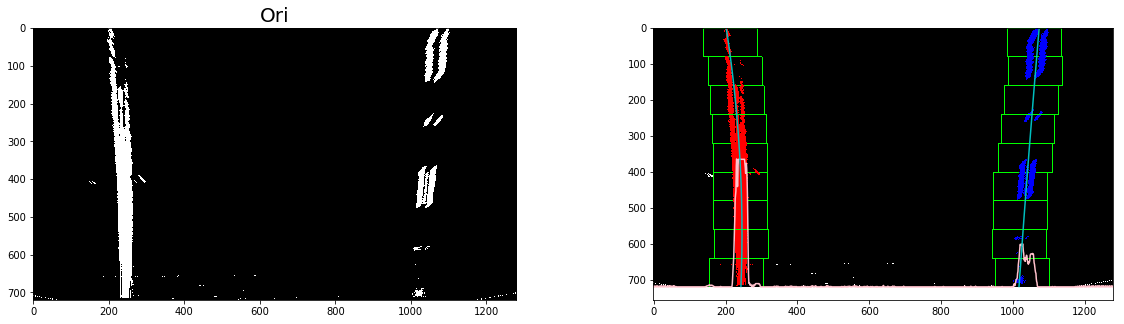

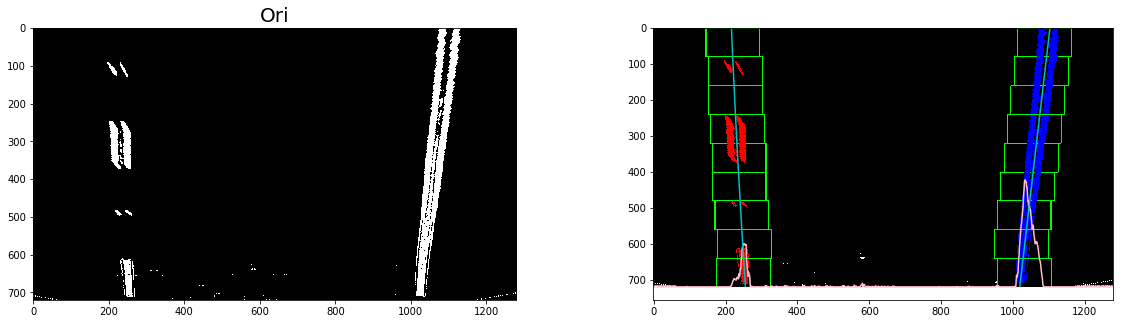

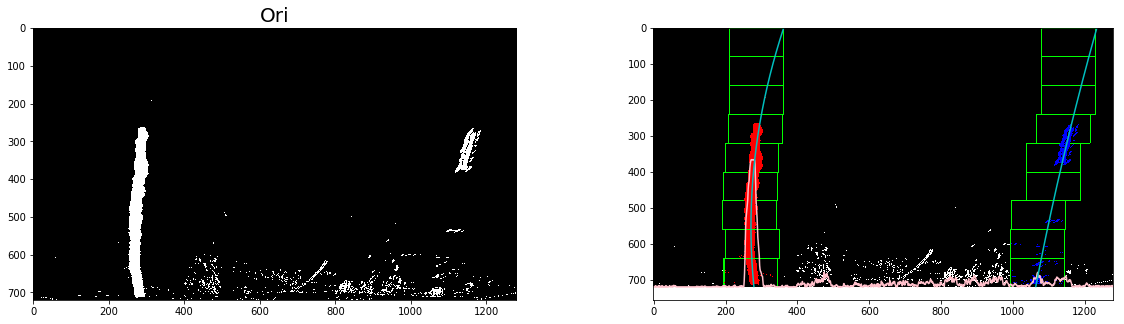

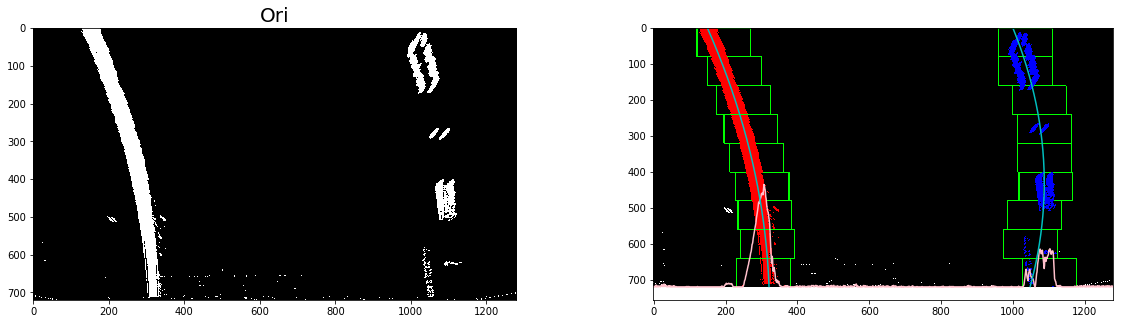

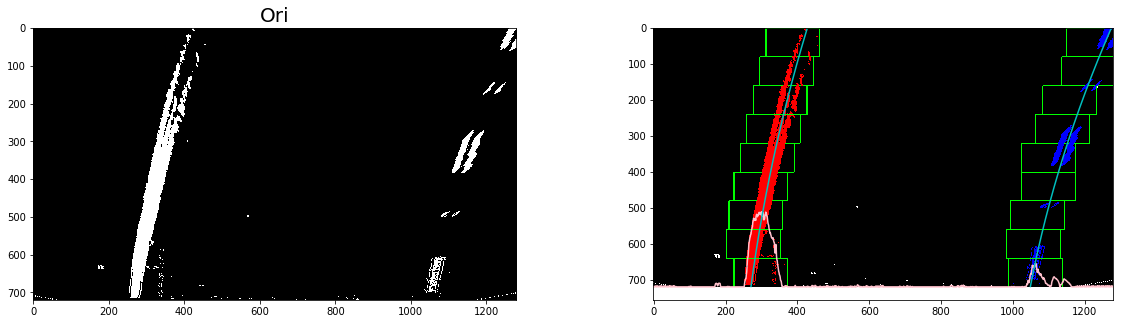

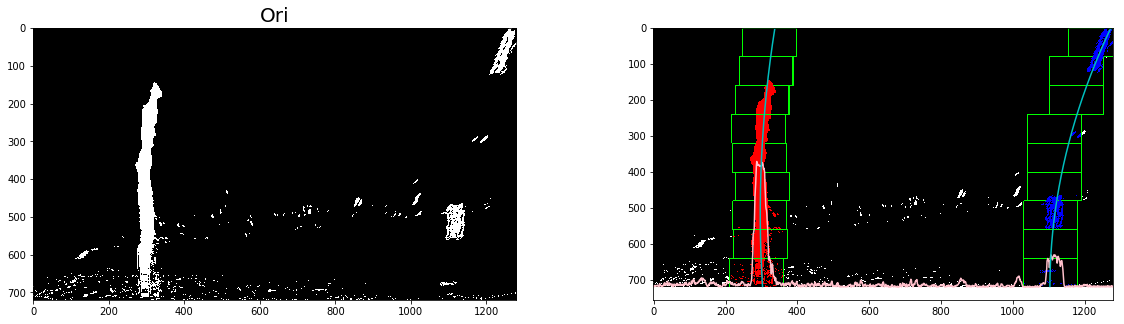

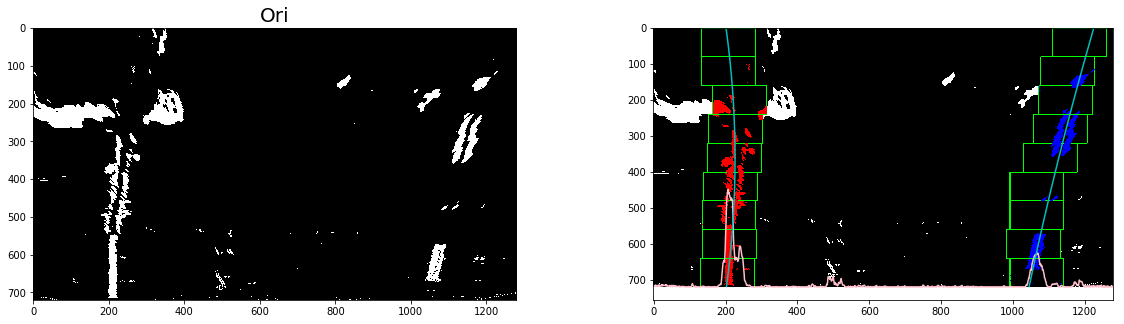

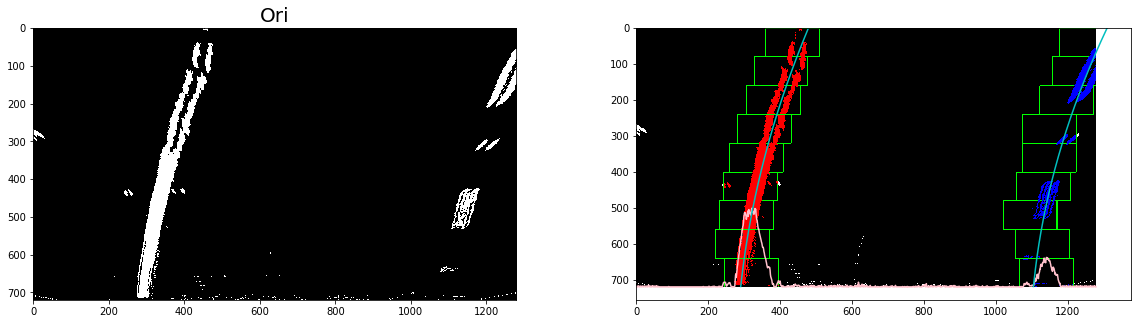

In [12]:
detectedLanes = []
for img in bin_warp_imgs:
    detectedLanes.append(detect_lane_edges(img, plot_enable=True))
    

In [13]:
def calc_curve_radius(limits,center):
    laneleft = limits[0]
    laneright = limits[1]
    
    ploty = np.linspace(0, 719, num=720)
    
    leftx = laneleft[0]*ploty**2 + laneleft[1]*ploty + laneleft[2]
    rightx = laneright[0]*ploty**2 + laneright[1]*ploty + laneright[2] 
    
    ym_per_pix = 30./720. # meters per pixel in y dimension
    xm_per_pix = 3.7/700. # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    left_radius = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_radius = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radius
    left_curverad = ((1 + (2*left_radius[0]*y_eval*ym_per_pix + left_radius[1])**2)**1.5) / np.absolute(2*left_radius[0])
    right_curverad = ((1 + (2*right_radius[0]*y_eval*ym_per_pix + right_radius[1])**2)**1.5) / np. absolute(2*right_radius[0])
    
    cam_pos2ctr = ((leftx[int(y_eval)] + rightx[int(y_eval)])/2 - center)*xm_per_pix
    return (left_curverad,right_curverad,cam_pos2ctr)

In [14]:
def LanePoly(img,plot_enable=False, display_curve_radius=True):
    
    limits = detect_lane_edges(img)
    
    laneleft = limits[0]
    laneright = limits[1]
    
    ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
    leftcoords = laneleft[0]*ploty**2 + laneleft[1]*ploty + laneleft[2]
    rightcoords = laneright[0]*ploty**2 + laneright[1]*ploty + laneright[2] 
    
    left = np.dstack((leftcoords,ploty))
    right = np.fliplr(np.dstack((rightcoords, ploty)))
    cmb = np.hstack((left,right)).astype('int')
    
    img_mask = np.zeros_like(img)
    cv2.fillPoly(img_mask,cmb,255)
    img_masked = cv2.bitwise_and(np.ones_like(img),img_mask)
    
    img_out = np.dstack(( np.zeros_like(img),img_masked*255,np.zeros_like(img)))
    
    crText = calc_curve_radius(limits,img.shape[1]/2)
 
    if plot_enable:    
        plt.figure()
        plt.imshow(img_out)
            
        plt.show()
    
    return img_out, crText


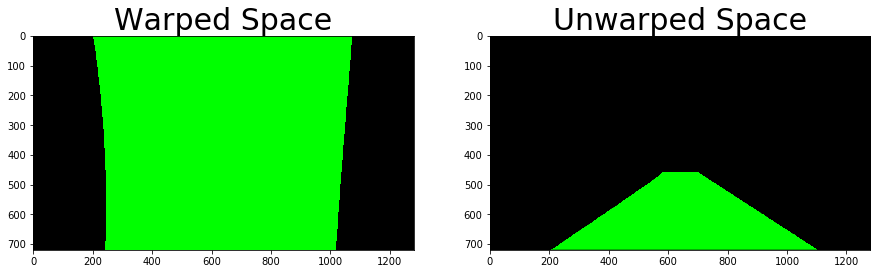

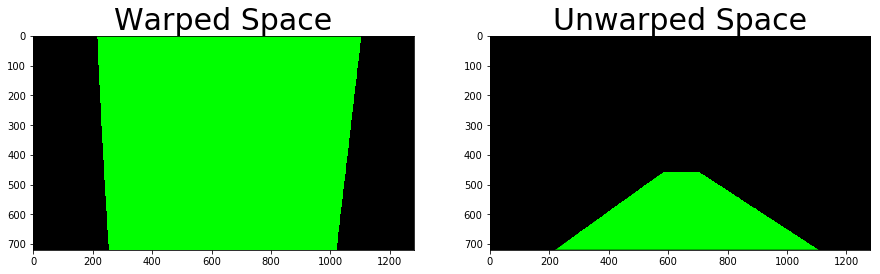

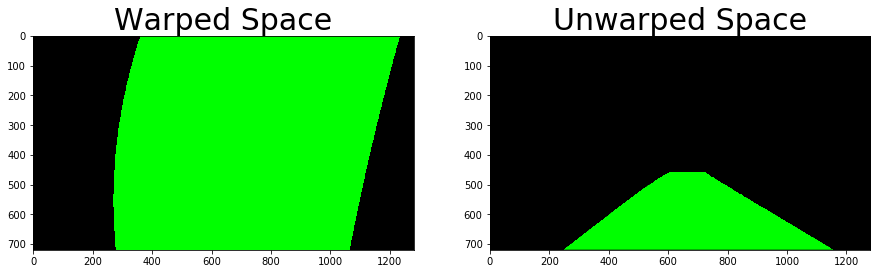

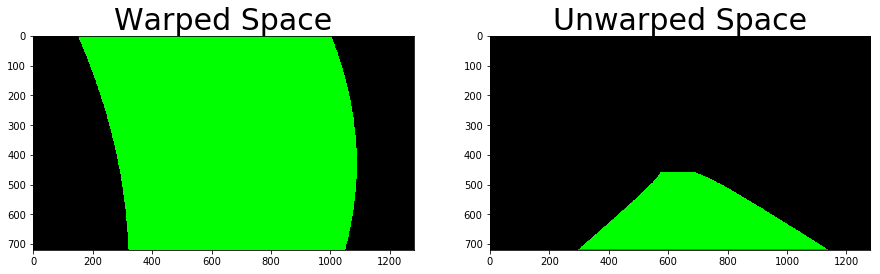

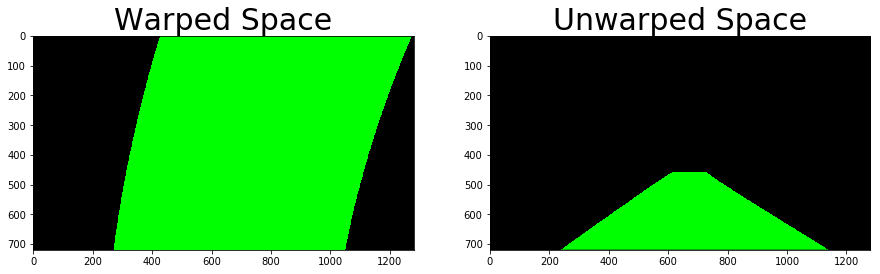

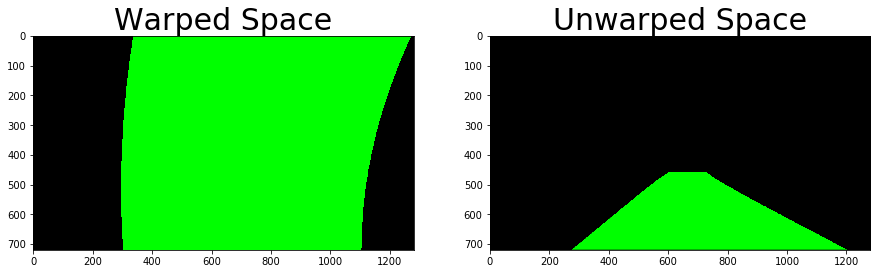

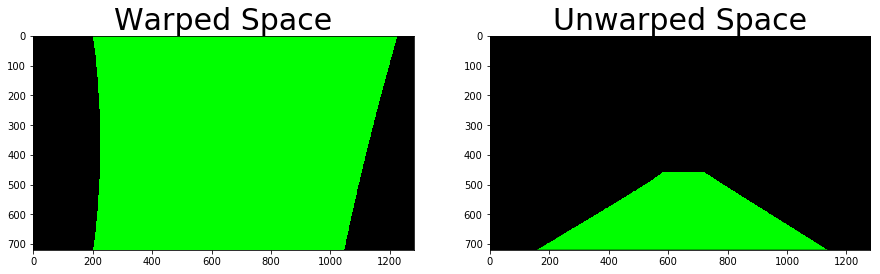

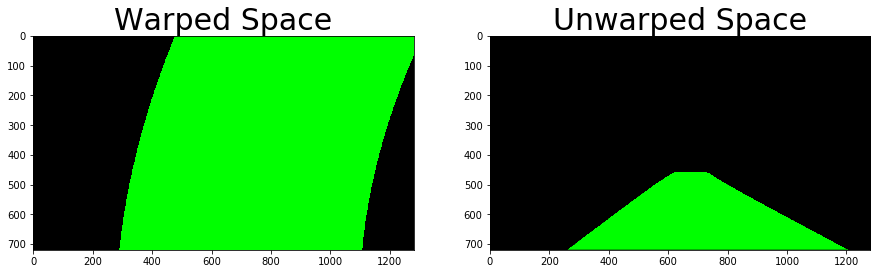

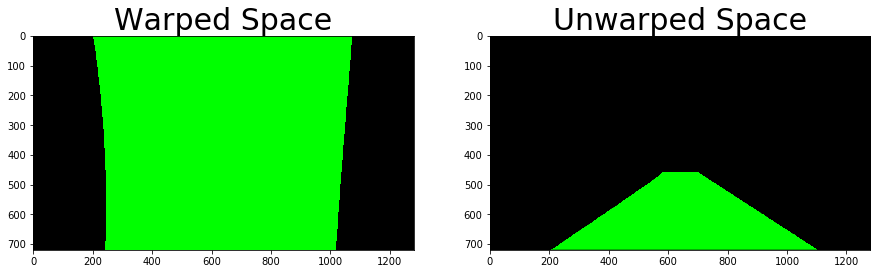

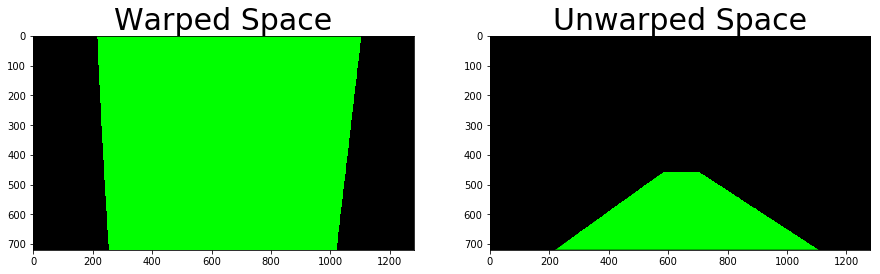

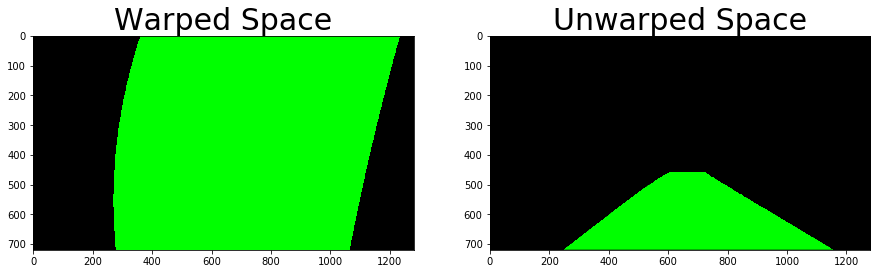

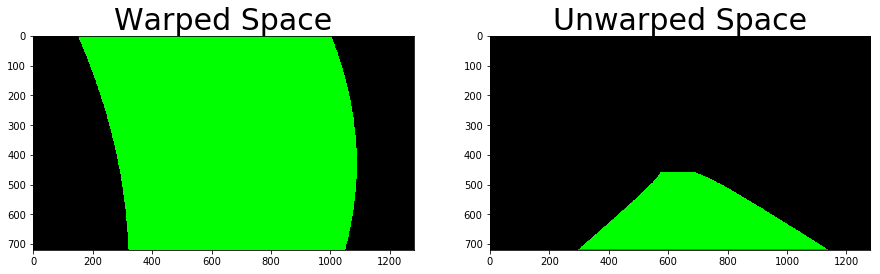

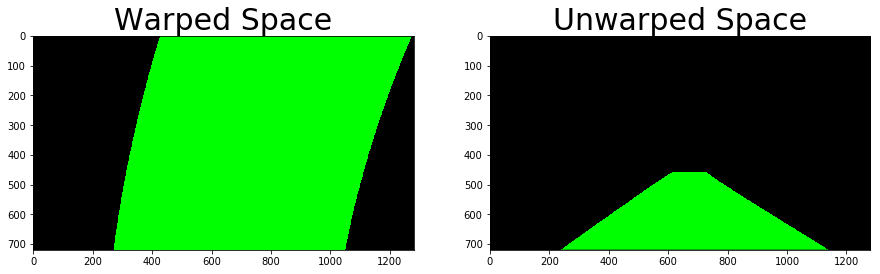

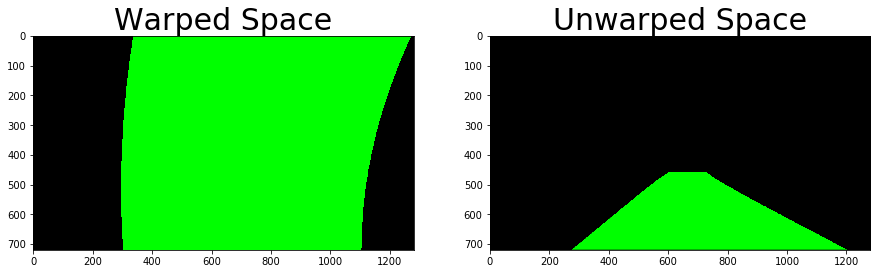

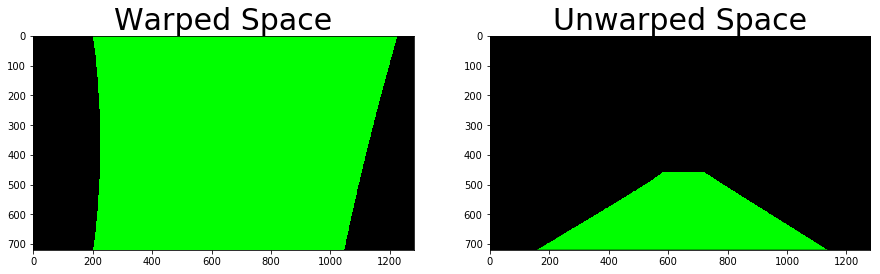

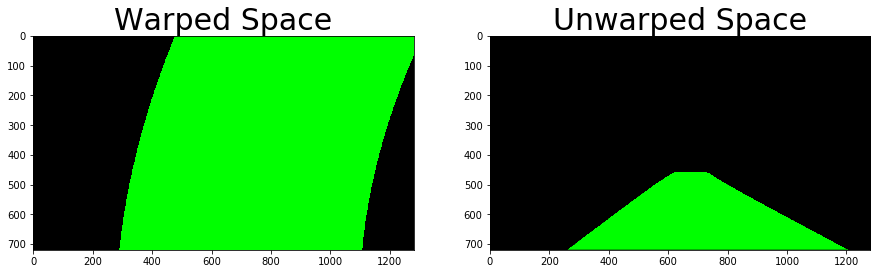

In [15]:
img_lane_masks = []
for img in bin_warp_imgs:
    img_warped, radius = LanePoly(img)
    
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    img_lane_masks.append(img_warped_back)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
    ax1.set_title('Warped Space', fontsize=30)
    ax1.imshow(img_warped)
    ax2.set_title('Unwarped Space', fontsize=30)
    ax2.imshow(img_warped_back)

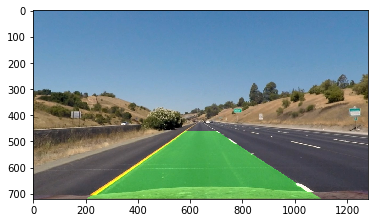

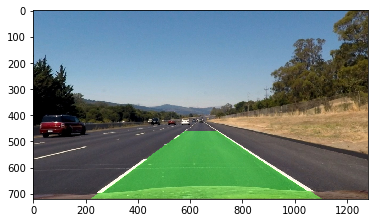

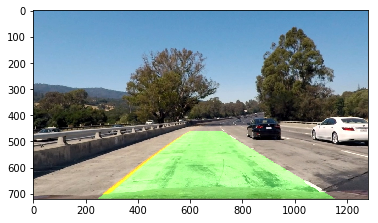

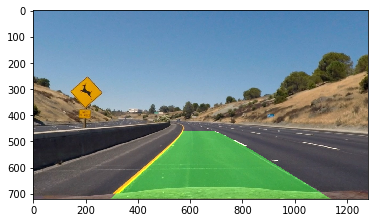

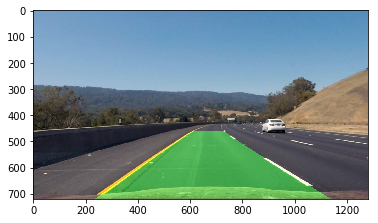

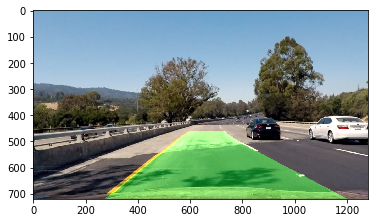

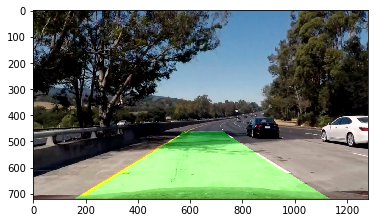

In [18]:
for img,overlay in zip(test_images_unsorted,img_lane_masks):
    img_overlayed = cv2.addWeighted(img, 1, overlay, 0.4, 0.0)
    if True:
        plt.figure()
        plt.imshow(img_overlayed)
    

In [19]:
def DisplayText(img, data):
    cv2.putText(img,'Left Radius" %d(m)'%data[0],(50,50),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    cv2.putText(img,'Right Radius: %d(m)'%data[1],(850,50),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    cv2.putText(img,'Cam Lane Pos: {0:.3f}(m)'.format(data[2]),(400,100),cv2.FONT_HERSHEY_SIMPLEX, 1, [0, 0, 0], 2)
    pass

In [20]:
def LineFinder(img):
    
    #Undistort incoming frame
    img_undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    #Warp image to birdseye view
    img_be = perspective_swap(img_undist)
    
    #Binary Threshold the Warped image
    img_be_bin = conv2LSBinary(img_be)
    
    #Detect Lane edges
    img_warped, data = LanePoly(img_be_bin)
    
    #Warp the Lane back to normal coordinates
    img_warped_back = perspective_swap(img_warped, swap_back=True)
    
    #Overlay calculated lane on original image
    img_overlayed = cv2.addWeighted(img_undist, 1, img_warped_back, 0.4, 0.0)
    
    #Overlay radius and car position in lane
    DisplayText(img_overlayed,data)
    
    if False:
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Undistorted Image', fontsize=20)
        ax1.imshow(img_undist)
        ax2.set_title('Warped Image', fontsize=20)
        ax2.imshow(img_be)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Warped Thresh Image', fontsize=20)
        ax1.imshow(img_be_bin, cmap='gray')
        ax2.set_title('Lane Lines Warped', fontsize=20)
        ax2.imshow(img_warped)
        
        f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(20,30))
        ax1.set_title('Unwarped Thresh Image', fontsize=20)
        ax1.imshow(img_warped_back, cmap='gray')
        ax2.set_title('Final Frame', fontsize=20)
        ax2.imshow(img_overlayed)
 
    return img_overlayed

In [21]:
tmp = LineFinder(test_images[0])


In [79]:
project_output_file = "project_output.mp4"
project_video = VideoFileClip("./project_video.mp4")
project_output = project_video.fl_image(LineFinder)
%time project_output.write_videofile(project_output_file, audio=False)

OSError: [WinError 6] The handle is invalid